# Notebook 1: Prelyminary Data Analysis

Last modified by Miriam, July 2nd 2025.

In [3]:
import pandas as pd
import re
import os
import sys
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from mice_inspection_utils import *
import matplotlib.gridspec as gridspec


imput_subj_paths = [f"Data/raw/total.full.rn.RA.total_OTU_table.mouse{i+1}.ovr0.0p.csv" for i in range(0, 8)]
output_subj_paths = [f"Data/by_mouse/mouse_{i+1}.csv" for i in range(0, 8)]
metadata_path = "Data/raw/OTU_table.csv"
mi = Mice_Inspection(ip = imput_subj_paths, op = output_subj_paths, mdp = metadata_path)

directory = "new_outputs_miriam"
os.makedirs(directory, exist_ok = True)

### A Sample time-series for the slides

In [2]:
mi.plot_species_NEW(subjects = [1, 2], save_fig = True, output_path = "new_outputs_miriam/ts_for_slides.png")

saved as new_outputs_miriam/ts_for_slides.png


# Stacked - bar Plots

Species: 1.260

Genus: 412

Family: 141

Order: 66

Class: 37

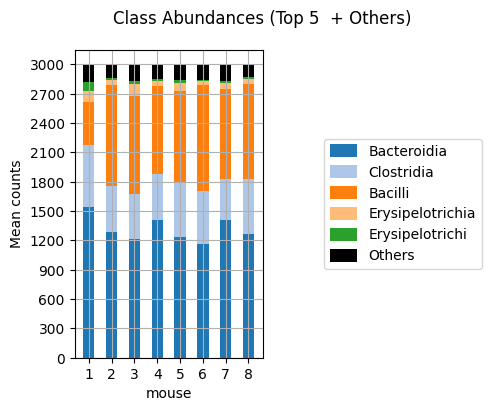

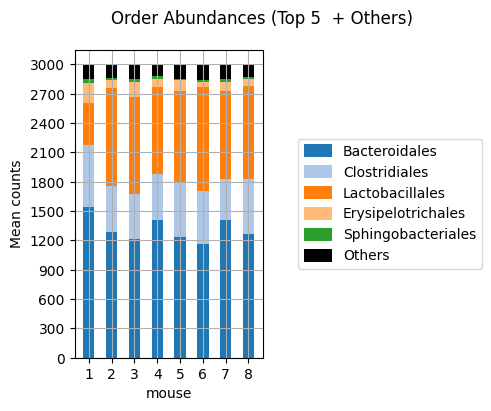

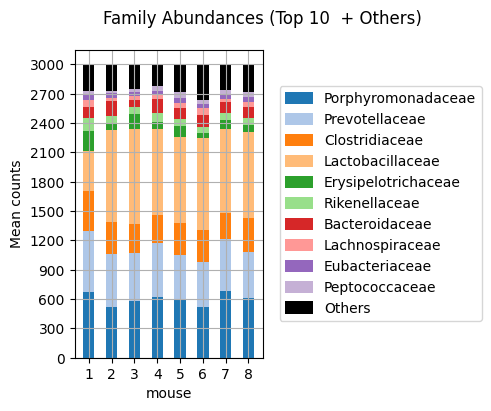

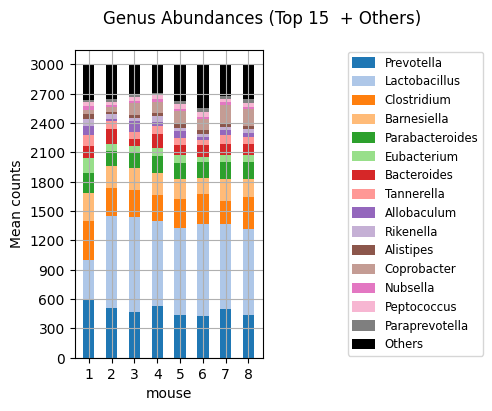

In [19]:
from functools import reduce
metadata_df = mi.metadata_df

def get_cathegory_df(cathegory = "Class", N = 40, grouped = True, which = "mean"):
    temp_df_list = []
    for mouse in range(0, 8):
        temp_df = mi.get_mice_df()[mouse].copy()
        temp_df["mean"] = temp_df.iloc[:, 1:].mean(axis=1)
        temp_df["median"] = temp_df.iloc[:, 1:].median(axis=1)
        temp_df = temp_df[["species", "mean", "median"]].copy()
        temp_df.rename(columns={"mean": f"mean_{mouse}", "median": f"median_{mouse}"}, inplace=True)
        temp_df_list.append(temp_df)
    """
    Join dataframes. Keep all species. If a species is not sampled for a mouse, add NA
    """
    df = reduce(lambda left, right: pd.merge(left, right, on="species", how="outer"), temp_df_list)
    """
    Add the information about the species taxonomic classification
    """
    info_df = mi.metadata_df[["Species", "Phylum", "Class", "Order", "Family", "Genus"]].drop_duplicates()
    info_df.rename(columns={"Species": "species"}, inplace=True)
    df = pd.merge(df, info_df, on="species", how="left")

    """
    Now filter by Cathegory, and group by mouse. Sum counts. 
    """
    if which == "both":
        mice_cols = [col for col in df.columns if (col.startswith("mean_") or col.startswith("median_"))]
    elif which == "mean":
        mice_cols = [col for col in df.columns if (col.startswith("mean_"))]
    else:
        mice_cols = [col for col in df.columns if (col.startswith("median_"))]
    cathegory_df = df.groupby(cathegory)[mice_cols].sum().reset_index()
    cathegory_df.head()


    """
    Order in descending order (use mouse_0)
    """
    df_plot = cathegory_df.copy()
    df_plot.sort_values(by = "mean_0", ascending = False, inplace = True)
    df_plot.reset_index(drop=True, inplace=True)
    df_plot.head()
    """
    Group all but first N genera in a unique row "Others"
    """
    if len(df_plot) > N:
        top_df = df_plot.iloc[:N].copy()
        others_df = df_plot.iloc[N:]
        others_sum = others_df.drop(columns=[cathegory]).sum()
        others_row = pd.DataFrame([["Others", *others_sum]], columns=df_plot.columns)
        df_plot_grouped = pd.concat([top_df, others_row], ignore_index=True)
    else:
        df_plot_grouped = df_plot.copy()
    """
    Normalize counts
    """
    #df_plot_grouped.iloc[:, 1:] /= mi.sample_size
    if grouped:
        return df_plot_grouped
    else:
        return df_plot



def plot_stacked(cathegory = "Genus", N = 10, figsize = (5, 4), save_fig= False, path = None, which = "mean"):
    df_plot_grouped = get_cathegory_df(cathegory = cathegory, N = N, grouped = True)
    # Settings
    colors = extended_tab20
    width = 0.5
    x_labels = [f"{j + 1}" for j in range(df_plot_grouped.shape[1] - 1)]  # exclude "Genus" column


    fig = plt.figure(figsize = figsize)
    gs = gridspec.GridSpec(nrows=1, ncols=6, figure=fig)
    ax1 = fig.add_subplot(gs[:, :3])
    ax2 = fig.add_subplot(gs[:, 3:])  

    bottom = np.zeros(len(x_labels))

    # Plot each category group
    for idx, row in df_plot_grouped.iterrows():
        label = row[cathegory]
        values = row.drop(labels=cathegory).to_numpy(dtype=float)
        color = "black" if label == "Others" else colors[idx % 20]
        ax1.bar(x_labels, values, width, label=label, bottom=bottom, color=color)
        bottom += values

    # Aesthetics
    #ax1.set_ylabel("Mean frequency")
    ax1.set_ylabel("Mean counts")
    ax1.set_xlabel("mouse")
    max_items_per_col = 40
    ncol = math.ceil(len(df_plot_grouped) / max_items_per_col)
    ax1.legend(#title=f"Most Abundant {cathegory}",
            bbox_to_anchor=(+2.2, 0.5),
            loc='right', ncol=ncol,
            handlelength=2, handleheight=1)#,
    if N > 10:
        ax1.legend(
            bbox_to_anchor=(+2.2, 0.5),
            loc='right', ncol=ncol,
            handlelength=2, handleheight=1,
            fontsize='small',
            title_fontsize='small')
    ax1.set_yticks(np.arange(0, 3001, 300))
    #ax1.set_yticks(np.arange(0, 1.1, 0.1))
    ax1.grid()
    ax2.axis("off")
    plt.suptitle(f"{cathegory} Abundances (Top {N}  + Others)")

    if (save_fig and path != None):
        plt.savefig(path, dpi = 300)
    return


plot_stacked(cathegory = "Class", figsize = (5,4), N = 5, save_fig = True, path = os.path.join(directory, "class_stacked.png"))
plot_stacked(cathegory = "Order", figsize = (5,4), N = 5, save_fig = True, path = os.path.join(directory, "order_stacked.png"))
plot_stacked(cathegory = "Family", figsize = (5,4), N = 10, save_fig = True, path = os.path.join(directory, "family_stacked.png"))
plot_stacked(cathegory = "Genus", figsize = (5,4), N = 15, save_fig = True, path = os.path.join(directory, "genus_stacked.png"))

## Species RAD

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


alpha= -1.0110523319279088
saved as new_outputs_miriam/ts_for_slides_rare.png


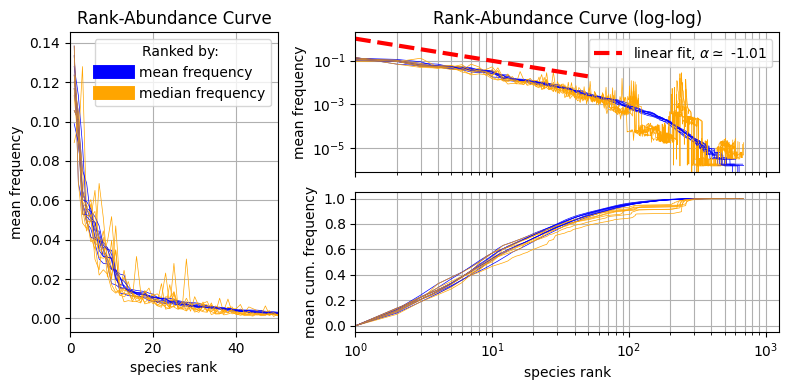

In [ ]:
out_path = os.path.join(directory, "RAD.png")


df_mice_by_mean  = mi.get_mice_df(sort_by = "mean")
df_mice_by_median  = mi.get_mice_df(sort_by = "median")

rad_by_mean = []
rad_by_median = []

for n in range(mi.subjects):
    df = df_mice_by_mean[n]
    y_mean = df.iloc[:, 1:].mean(axis = 1) / mi.sample_size # frequencies
    rad_by_mean.append(y_mean)

    df = df_mice_by_median[n]
    y_median = df.iloc[:, 1:].mean(axis = 1) / mi.sample_size # frequencies
    rad_by_median.append(y_median)

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(8, 4))

gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[1, 1], width_ratios=[3, 3, 2])
# Example: ax1 takes the left two-thirds of the top row
ax1 = fig.add_subplot(gs[0, 1:3])

# Example: ax2 takes the right one-third of the top row
ax2 = fig.add_subplot(gs[1, 1:3])

ax3 = fig.add_subplot(gs[:, 0])

ax = [ax1, ax2, ax3]



l = 0.5 # linewidth
color_mean = "blue"
color_median = "orange"

for n in range(mi.subjects):
    # RAD by mean
    y = rad_by_mean[n]
    x_max = len(y)
    x = np.arange(1, x_max + 1)
    y_cum = [np.sum(y[0:(rank - 1)]) for rank in x] # cum frequencies
    if n == 0:
        ax[0].plot(x, y, color = color_mean, linewidth = l)#, label = f'mean frequency')
        ax[2].plot(x, y, color = color_mean, linewidth = l, label = f'mean frequency')
        ax[1].plot(x, y_cum, color = color_mean,linewidth = l)#, label = f'mean frequency')
    else:
        # no label
        ax[0].plot(x, y, color = color_mean, linewidth = l)
        ax[2].plot(x, y, color = color_mean, linewidth = l)
        ax[1].plot(x, y_cum, color = color_mean, linewidth = l)

    # RAD by median
    y = rad_by_median[n]
    x_max = len(y)
    x = np.arange(1, x_max + 1)
    y_cum = [np.sum(y[0:(rank - 1)]) for rank in x] # cum frequencies
    if n == 0:
        ax[0].plot(x, y, color = color_median, linewidth = l)#, label = f'median frequency')
        ax[2].plot(x, y, color = color_median, linewidth = l, label = f'median frequency')
        ax[1].plot(x, y_cum, color = color_median, linewidth = l)#, label = f'median frequency')
    else:
        # no label
        ax[0].plot(x, y, linewidth = l, color = color_median)
        ax[2].plot(x, y, linewidth = l, color = color_median)
        ax[1].plot(x, y_cum, linewidth = l, color = color_median)

# Power law fit
from scipy.stats import linregress
y = rad_by_mean[0]
x_max = len(y)
x = np.arange(1, x_max + 1)
log_x = np.log(x)[0:50]
log_y = np.log(y)[0:50]
result = linregress(x = log_x, y = log_y)
print("alpha=",result.slope)
y_fit = np.exp(np.log(x)[0:50] * result.slope)
ax[0].plot(x[0:50], y_fit, color = "red", linestyle = "dashed", linewidth = 3, label = fr"linear fit, $\alpha \simeq$ {result.slope:.2f}")
ax[0].legend()


# Global plot aestethics
ax[0].set_xlim(1, 1260)
ax[0].tick_params(labelbottom=False)
ax[1].set_xlim(1, 1260)
ax[0].set_title("Rank-Abundance Curve (log-log)", fontsize = 'large')
ax[0].set_xlabel("")
ax[0].set_ylabel("mean frequency")
ax[0].grid(which= "both", axis = "x")
ax[0].grid(which= "major", axis = "y")
legend = ax[2].legend(title = "Ranked by: ")
for line in legend.get_lines():
    line.set_linewidth(10)

ax[2].set_xlim(0, 50)
ax[2].set_xticks(np.arange(0, 50, 20))
ax[2].set_xlabel("species rank")
ax[2].set_title("Rank-Abundance Curve", fontsize = 'large')
ax[2].set_ylabel("mean frequency")
ax[2].grid(which= "both", axis = "x")
ax[2].grid(which= "major", axis = "y")


#ax[1].set_title("Cum. Rank-Abundance Curve", fontsize = 'large')
ax[1].set_xlabel("species rank")
ax[1].set_ylabel("mean cum. frequency")
ax[1].set_yticks(np.arange(0, 1.1, 0.2))
ax[1].grid(which= "both", axis = "x")
ax[1].grid(which= "major", axis = "y")


ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_xscale("log")


plt.subplots_adjust(wspace = 0.4)
plt.tight_layout()
plt.savefig(out_path, dpi = 600)


rare_species = ['Vibrio cholerae', '[Eubacterium] biforme', 'Streptococcus sp. B1']
mi.plot_species_MEAN_ONLY(species_list = rare_species, size = (4,2.5), save_fig = True, output_path = "new_outputs_miriam/ts_for_slides_rare.png")

## How reliable is the species label?

OTUs come with a % confidence score on the species assignation. Every read will map to a different OTU, this is why there are more OTUs than species.
We would like to discard OTUs that have a low confidence on the species. But how 
The unique identifier of an OTU is the SEQUENCE ??


% id,alignment length,mismatches,gap openings,e-value,bit score,coverage,sequence


Let's see how many samples have a confidence level > ( 1 - threshold ), for threshold values ranging in [0, 1]. 

37 66 141 412 1260


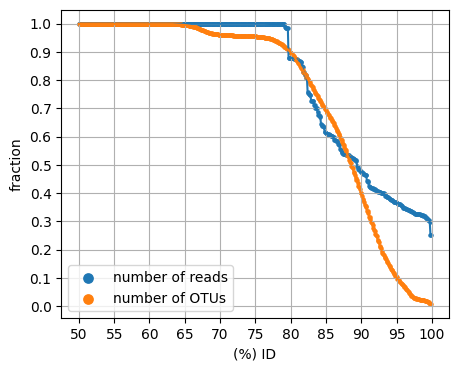

In [5]:
metadata_df = pd.read_csv(metadata_path)



total_species = len(np.unique(metadata_df['Species']))
total_genus = len(np.unique(metadata_df['Genus']))
total_family = len(np.unique(metadata_df['Family']))
total_order = len(np.unique(metadata_df['Order']))
total_class = len(np.unique(metadata_df['Class']))


print(total_class, total_order, total_family, total_genus, total_species)


df = metadata_df[["query", "total_reads", "% id"]]
df.head()
total_ = df["total_reads"].sum()
total_otus = len(df)

thresholds = np.arange(50, 100, 0.1)
reads_fraction = np.zeros(len(thresholds))
otus_fraction = np.zeros(len(thresholds))

for i, t in enumerate(thresholds):
    reads_fraction[i] = df[df["% id"] > t]["total_reads"].sum() / total_
    otus_fraction[i] = len(df[df["% id"] > t]["total_reads"]) / total_otus


fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,4))
ax.scatter(thresholds, reads_fraction, s = 5, label = "number of reads")
ax.plot(thresholds, reads_fraction)
ax.grid(which = "both")
ax.set_xlabel("(%) ID")
ax.set_ylabel("fraction")
ax.set_xticks(np.arange(50, 101, 5))
ax.set_yticks(np.arange(0, 1.1, 0.1))
#ax.set_xticklabels(np.arange(0, 1.1, 0.1))

ax.scatter(thresholds, otus_fraction, s = 5, label = "number of OTUs")
ax.plot(thresholds, otus_fraction)
ax.legend(markerscale = 3)

output_path = os.path.join(directory, "assignment_confidence.png")
plt.savefig(output_path, dpi = 600)

Comments: clearly we should forget about the typical confidence levels used in physics. With a Cl of 95%, for instance, we would discard over 60% of the reads!

A reasonable choice could be a CL 0f 80%... Still, pretty low for a physicist's standard. We should keep in mind for all subsequent analysis that this is the data we work with.

## Genus Aggregated Data

Since the confidence on the species label is not high, it may be reasonable to aggregate the data at a higher taxonomic rank — namely, the Genus level.


Such choice is motivated by the assumption that species belonging to the same Genus are similiar, and we expect them to follow a similiar temporal path.

We need to check if this assumption holds. There are many ways we can do that, but lets keep it simple.

- 1. **Pairwise correlations** Let's compute correlatgions between all pairs of species time series. Are correlations within the same genus (intra-genus) significantly higher than those between different genera (inter-genus)?

- 2. **Shape similarity** Also, we can define a similarity measure for the shape of the time series in this way. First, we normalize each time series so that it is centered in 0 with std 1. Then we encode each series as a vector in $\mathcal{R}^D$, where $D$ is the number of measures, and we compute pairwise distances. This should give a geometric sense of how similar the time series shapes are.



**Note** Aggregating data at the Genus level may also benefit the task of **interaction network** inference. Indeed, one of the main difficulty of an inference problem on a graph is that it needs a lot of data samples. A common workaround is to restrict the analysis to the top-ranked species, for example by selecting only the top 100 most abundant. However, this approach tends to overrepresent a small number of genera (e.g., Prevotella and Lactobacillus).Interactions within a genus are often competitive (negative), as species compete for similar resources, but these are less interesting than mixed-sign interactions.

By aggregating at the genus level, we reduce the number of nodes while retaining broader taxonomic diversity. This increases the likelihood of observing more biologically meaningful interaction, even if we put a threshold on the network size.

### 1. Analysis of intra-genus and inter-genus mean pairwise correlations


We dont consider all species belonging to the genus, but only those species which have a mean abundance over some threshold. From the species RAD distribution, we see that >0.9 of all reads come from species with a frequency>=10^-3, which is mean counts >=3.

We exclude species below this threshold because their time series is likely made of all near-zeros values, basically noise.

Mean correlation for genus Prevotella=  0.29200574330144935
Mean correlation for genus Lactobacillus=  0.2522362266897536


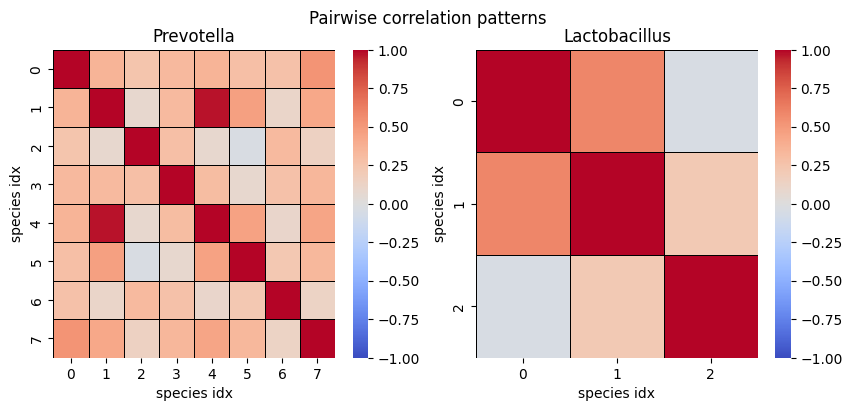

In [22]:
metadata_df = mi.metadata_df
unique_combos = metadata_df[['Genus', 'Species']].drop_duplicates()
mapping = dict(zip(unique_combos['Species'], unique_combos['Genus']))
np.unique(mapping.values())
df = pd.read_csv("Data/by_mouse_transposed/mouse_1_transposed.csv")


def species_list(genus, df, filter = True, threshold = 3):
    """
    Selects species in the mouse dataframe (df) that belong to the chosen genus.
    Optionally, it also filters the list, returning only those species with a median abundance over a certain threshold.
    """
    species = df.columns[1:]
    if filter and (threshold is not None):
        bool_mask = [(mapping[f'{species_}']== f"{genus}" and (df[f'{species_}'].median() > threshold) ) for species_ in species]
    else: 
         bool_mask = [(mapping[f'{species_}']== f"{genus}") for species_ in species]
    filtered_species = species[bool_mask].to_list()
    num_species = len(filtered_species)
    return filtered_species, num_species


def genus_corr(genus_a, genus_b):
    """
    Computes the average pairwise correlation of time series of species belonging to same genus.
    """
    df = pd.read_csv("Data/by_mouse_transposed/mouse_1_transposed.csv")
    filtered_species_a, num_species_a = species_list(genus_a, df)
    filtered_species_b, num_species_b = species_list(genus_b, df)
    if num_species_a < 1 or num_species_b <1:
        estimated_pearson = None
        return
    series_a = {s: df[s].values for s in filtered_species_a}
    series_b = {s: df[s].values for s in filtered_species_b}

    estimated_covariance = np.full((num_species_a, num_species_b), np.nan)
    estimated_pearson = np.full((num_species_a, num_species_b), np.nan)

    for i, s_a in enumerate(filtered_species_a):
        a = series_a[s_a]
        for j, s_b in enumerate(filtered_species_b):
            b = series_b[s_b]

            mask = ~np.isnan(a) & ~np.isnan(b)
            if np.sum(mask) > 1:
                a_masked = a[mask]
                b_masked = b[mask]

                cov = np.cov(a_masked, b_masked)[0, 1]
                denom = np.sqrt(np.var(a_masked) * np.var(b_masked))

                estimated_covariance[i, j] = cov
                if denom > 0:
                    estimated_pearson[i, j] = cov / denom
    mean_val = np.nan
    if (estimated_pearson is not None) and (genus_a == genus_b):
        """
        Compute the mean of off-diagonal entries only (cross-correlations)
        """
        diag_mask = ~np.eye(estimated_pearson.shape[0], estimated_pearson.shape[1], dtype=bool)
        mean_val = np.nanmean(estimated_pearson[diag_mask])
    elif (estimated_pearson is not None) and (genus_a != genus_b):
        """
        Compute the mean of all entries
        """
        mean_val = np.nanmean(estimated_pearson)
    return estimated_pearson, mean_val

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
ax = axs.flatten()

genus = "Prevotella"
estimated_pearson, mean_val = genus_corr(genus, genus)
print(f"Mean correlation for genus {genus}= ", mean_val)
sns.heatmap(estimated_pearson, ax = ax[0], annot=False, cmap='coolwarm', linecolor = "black", vmin = -1, vmax = +1, linewidths=0.5, cbar=True)
ax[0].set_title(genus)
ax[0].set_xlabel("species idx")
ax[0].set_ylabel("species idx")

genus = "Lactobacillus"
estimated_pearson, mean_val = genus_corr(genus, genus)
print(f"Mean correlation for genus {genus}= ", mean_val)
sns.heatmap(estimated_pearson, ax = ax[1], annot=False, cmap='coolwarm', linecolor = "black", vmin = -1, vmax = +1, linewidths=0.5, cbar=True)
ax[1].set_title(genus)
ax[1].set_xlabel("species idx")
ax[1].set_ylabel("species idx")

plt.suptitle("Pairwise correlation patterns")

plt.savefig(os.path.join(directory, "intra_genus_correlation_patterns.png"), dpi = 300)

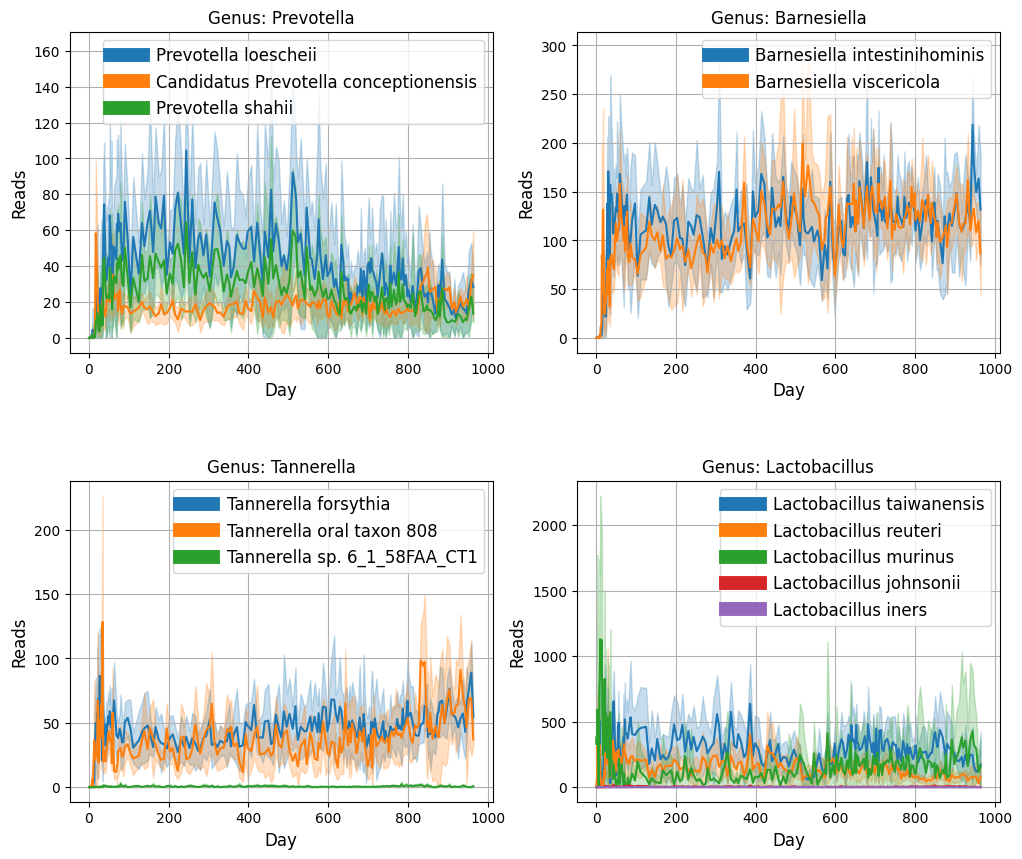

In [52]:
df = pd.read_csv("Data/by_mouse_transposed/mouse_1_transposed.csv")




fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 10))
axs = axs.flatten()


ax = axs[0]
genus = "Prevotella"
species_, _ = species_list(genus=genus, df = df, filter = False)
species_ = [species_[1], species_[3], species_[4]]
for i,species in enumerate(species_):
    imput_path = os.path.join("Data", "by_species", f"{species}.csv")
    while not os.path.exists(imput_path):
        species_df = mi.get_species_df(species)
    species_df = pd.read_csv(imput_path)
    # Plot mean and std
    valid_data = species_df[['day', 'mean', 'std']].dropna()
    ax.plot(valid_data['day'], valid_data['mean'], linewidth = 1.5, color = colors(i % 10), label = f'{species}')
    ax.fill_between(x=valid_data['day'], y1 = np.maximum(valid_data['mean'] - valid_data['std'], 0), y2=valid_data['mean'] + valid_data['std'], color = colors(i % 10), alpha=0.25)
ax.set_xlabel("Day", fontsize = 'large')
ax.set_ylabel("Reads", fontsize = 'large')
legend = ax.legend( fontsize = 'large', loc = 'upper right')
for line in legend.get_lines():
    line.set_linewidth(10)
ax.grid(True)
ax.set_title(f"Genus: {genus}")




ax = axs[1]
genus = "Barnesiella"
species_, _ = species_list(genus=genus, df = df, filter = False)
species_ = species_[0:5]
for i,species in enumerate(species_):
    imput_path = os.path.join("Data", "by_species", f"{species}.csv")
    while not os.path.exists(imput_path):
        species_df = mi.get_species_df(species)
    species_df = pd.read_csv(imput_path)
    # Plot mean and std
    valid_data = species_df[['day', 'mean', 'std']].dropna()
    ax.plot(valid_data['day'], valid_data['mean'], linewidth = 1.5, color = colors(i % 10), label = f'{species}')
    ax.fill_between(x=valid_data['day'], y1 = np.maximum(valid_data['mean'] - valid_data['std'], 0), y2=valid_data['mean'] + valid_data['std'], color = colors(i % 10), alpha=0.25)
ax.set_xlabel("Day", fontsize = 'large')
ax.set_ylabel("Reads", fontsize = 'large')
legend = ax.legend( fontsize = 'large', loc = 'upper right')
for line in legend.get_lines():
    line.set_linewidth(10)
ax.grid(True)
ax.set_title(f"Genus: {genus}")




ax = axs[2]
genus = "Tannerella"
species_, _ = species_list(genus=genus, df = df, filter = False)
species_ = species_[0:5]
for i,species in enumerate(species_):
    imput_path = os.path.join("Data", "by_species", f"{species}.csv")
    while not os.path.exists(imput_path):
        species_df = mi.get_species_df(species)
    species_df = pd.read_csv(imput_path)
    # Plot mean and std
    valid_data = species_df[['day', 'mean', 'std']].dropna()
    ax.plot(valid_data['day'], valid_data['mean'], linewidth = 1.5, color = colors(i % 10), label = f'{species}')
    ax.fill_between(x=valid_data['day'], y1 = np.maximum(valid_data['mean'] - valid_data['std'], 0), y2=valid_data['mean'] + valid_data['std'], color = colors(i % 10), alpha=0.25)
ax.set_xlabel("Day", fontsize = 'large')
ax.set_ylabel("Reads", fontsize = 'large')
legend = ax.legend( fontsize = 'large', loc = 'upper right')
for line in legend.get_lines():
    line.set_linewidth(10)
ax.grid(True)
ax.set_title(f"Genus: {genus}")







ax = axs[3]
genus = "Lactobacillus"
species_, _ = species_list(genus=genus, df = df, filter = False)
species_ = species_[0:5]
for i,species in enumerate(species_):
    imput_path = os.path.join("Data", "by_species", f"{species}.csv")
    while not os.path.exists(imput_path):
        species_df = mi.get_species_df(species)
    species_df = pd.read_csv(imput_path)
    # Plot mean and std
    valid_data = species_df[['day', 'mean', 'std']].dropna()
    ax.plot(valid_data['day'], valid_data['mean'], linewidth = 1.5, color = colors(i % 10), label = f'{species}')
    ax.fill_between(x=valid_data['day'], y1 = np.maximum(valid_data['mean'] - valid_data['std'], 0), y2=valid_data['mean'] + valid_data['std'], color = colors(i % 10), alpha=0.25)
ax.set_xlabel("Day", fontsize = 'large')
ax.set_ylabel("Reads", fontsize = 'large')
legend = ax.legend( fontsize = 'large', loc = 'upper right')
for line in legend.get_lines():
    line.set_linewidth(10)
ax.grid(True)
ax.set_title(f"Genus: {genus}")


plt.subplots_adjust(wspace = 0.2, hspace = 0.4)

plt.savefig(os.path.join(directory, "ts_correlation_examples.png"), dpi = 300)

   # plt.savefig(output_path, dpi = 500)
   # print(f"saved as {output_path}")
   # plt.close()

In [41]:
df = pd.read_csv("Data/by_mouse_transposed/mouse_1_transposed.csv")
genera = np.unique(list(mapping.values()))
bool_mask =  np.full(len(genera), False, dtype=bool)
for i,genus in enumerate(genera):
    _, num_species = species_list(genus, df)
    if num_species > 1:
        bool_mask[i] = True
populated_genera = genera[bool_mask]
print(populated_genera)

genera = populated_genera
mean_correlation = np.zeros(shape = (len(genera), len(genera)))

from functools import lru_cache
@lru_cache(maxsize=None)
def cached_genus_corr(g1, g2):
    return genus_corr(g1, g2)


for i, genus_a in enumerate(genera):
    for j in range(i + 1, len(genera)):
        genus_b = genera[j]
        corr, mean = cached_genus_corr(genus_a, genus_b)
        mean_correlation[i, j] = mean
        mean_correlation[j, i] = mean


for i, genus in enumerate(genera):
    corr, mean = cached_genus_corr(genus, genus)
    mean_correlation[i, i] = mean

['Alistipes' 'Bacteroides' 'Barnesiella' 'Clostridium' 'Eubacterium'
 'Lactobacillus' 'Oscillibacter' 'Prevotella' 'Tannerella']


Mean inter genus:  0.008029005373612083
Mean intra genus:  0.3596072843073501


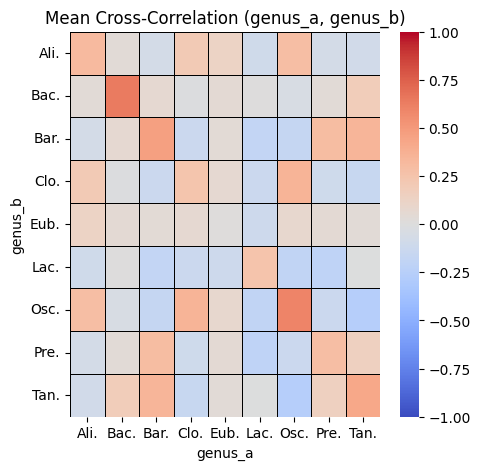

In [50]:
shortened = [word[:3]+ "." for word in genera]

plt.figure(figsize=(5, 5))
sns.heatmap(mean_correlation, xticklabels = shortened, yticklabels = shortened, annot=False, cmap='coolwarm', vmin = -1, vmax = +1, linecolor = "black", linewidths=0.5, cbar=True)
plt.xticks(rotation=0)   # Rotate x-axis labels
plt.yticks(rotation=0)    # Rotate y-axis labels
plt.xlabel("genus_a")
plt.ylabel("genus_b")
plt.title("Mean Cross-Correlation (genus_a, genus_b)")
plt.savefig(os.path.join(directory, "genera_cross_corr_pattern.png"), dpi = 300)

mean_inter_genus = np.nanmean(mean_correlation[~np.eye(mean_correlation.shape[0], dtype=bool)])
mean_intra_genus = np.nanmean(np.diag(mean_correlation))

print("Mean inter genus: ", mean_inter_genus)
print("Mean intra genus: ", mean_intra_genus)

### 2. Analysis of euclidean distances

mean cross- distance for Prevotella: 17.267186455873237


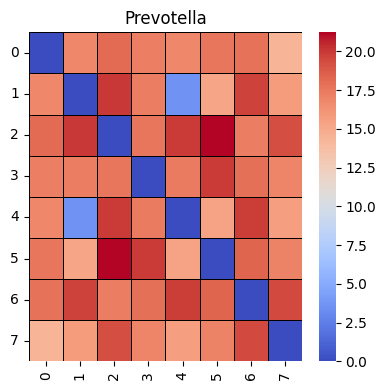

In [24]:
def genus_distance(genus_a, genus_b):
    filtered_species_a, num_species_a = species_list(genus_a, df)
    filtered_species_b, num_species_b = species_list(genus_b, df)
    if num_species_a < 1 or num_species_b <1:
        estimated_distance = None
        return estimated_distance
    estimated_distance = np.zeros(shape = (num_species_a, num_species_b))

    for i, s_a in enumerate(filtered_species_a):
        for j, s_b in enumerate(filtered_species_b):
            a = df[f"{s_a}"]
            b = df[f"{s_b}"]
            mask = ~np.isnan(a) & ~np.isnan(b)
            if np.sum(mask) > 1:
                a_normalized = ( a[mask] - np.mean(a[mask]) ) / np.std(a[mask])
                b_normalized = ( b[mask] - np.mean(b[mask]) ) / np.std(b[mask])
                estimated_distance[i, j] = np.linalg.norm(a_normalized - b_normalized)
            else:
                estimated_distance[i, j] = np.nan

    mean_val = np.nan
    if (estimated_distance is not None) and (genus_a == genus_b):
        """
        Compute the mean of off-diagonal entries only (cross-correlations)
        """
        diag_mask = ~np.eye(estimated_distance.shape[0], estimated_distance.shape[1], dtype=bool)
        mean_val = np.nanmean(estimated_distance[diag_mask])
    elif (estimated_distance is not None) and (genus_a != genus_b):
        """
        Compute the mean of all entries
        """
        mean_val = np.nanmean(estimated_distance)
    return estimated_distance, mean_val



genus = "Prevotella"
distance_prevotella, mean = genus_distance(genus, genus)
print(f"mean cross- distance for {genus}: {mean}")
plt.figure(figsize=(4, 4))
sns.heatmap(distance_prevotella, annot=False, cmap='coolwarm', linecolor = "black", linewidths=0.5, cbar=True)
plt.xticks(rotation=90)   # Rotate x-axis labels
plt.yticks(rotation=0)    # Rotate y-axis labels
plt.title(genus)
plt.tight_layout()
plt.show()   


genera = populated_genera
mean_distance = np.zeros(shape = (len(genera), len(genera)))

from functools import lru_cache
@lru_cache(maxsize=None)
def cached_genus_distance(g1, g2):
    return genus_distance(g1, g2)

for i, genus_a in enumerate(genera):
    for j in range(i + 1, len(genera)):
        genus_b = genera[j]
        dist, mean = cached_genus_distance(genus_a, genus_b)
        mean_distance[i, j] = mean
        mean_distance[j, i] = mean 


for i, genus in enumerate(genera):
    dist, mean = cached_genus_distance(genus, genus)
    mean_distance[i, i] = mean


Mean inter genus:  20.622740262530826
Mean intra genus:  16.42994602495872


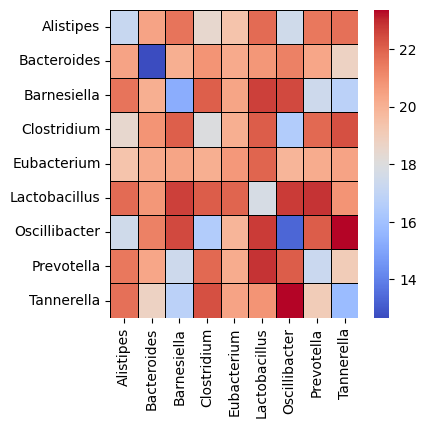

In [25]:
plt.figure(figsize=(4, 4))
sns.heatmap(mean_distance, annot=False,  xticklabels = genera, yticklabels = genera, cmap='coolwarm', linecolor = "black", linewidths=0.5, cbar=True)


mean_inter_genus = np.mean(mean_distance[~np.eye(mean_distance.shape[0], dtype=bool)])
mean_intra_genus = np.mean(np.diag(mean_distance))

print("Mean inter genus: ", mean_inter_genus)
print("Mean intra genus: ", mean_intra_genus)
plt.savefig("genera_distance.png")

### Timeseries of the first 20 Genera

## Genus RAD, threshold 


Now we look again at the rank- abundance distribution and the its cumulative version, but we aggregate the counts by "Genus" and not by species anymore.

We need to identify a reasonable threshold on the abbundance to decide which Genera are worth anaylizing in the following sections. 

If a time series is almost zero, there is no reason to analyze it. Genera are around 140. Lets see how many have sufficiently high abbundances.

In [52]:
genus_df = get_cathegory_df(cathegory = "Genus", N =200, which = "both", grouped = False)
genus_df.head()

mean_cols =  [col for col in genus_df.columns if col.startswith("mean_")]
median_cols =  [col for col in genus_df.columns if col.startswith("median_")]


genus_df["mean_frequency"] = genus_df[mean_cols].mean(axis = 1) / mi.sample_size
#genus_df["median_frequency"] = genus_df[median_cols].mean(axis = 1) / mi.sample_size
df = genus_df.copy().drop(columns = [col for col in genus_df.columns if (col not in ["Genus", "mean_frequency" , "median_frequency"])]).sort_values(by = "mean_frequency", ascending = False).reset_index(drop = True)

df["cum_mean_frequency"] = df["mean_frequency"].cumsum()
#df["cum_median_frequency"] = df["median_frequency"].cumsum()

df.head()

,Genus,mean_frequency,cum_mean_frequency
0,Lactobacillus,0.281426,0.281426
1,Prevotella,0.162437,0.443863
2,Clostridium,0.100481,0.544343
3,Barnesiella,0.071719,0.616063
4,Parabacteroides,0.057051,0.673113


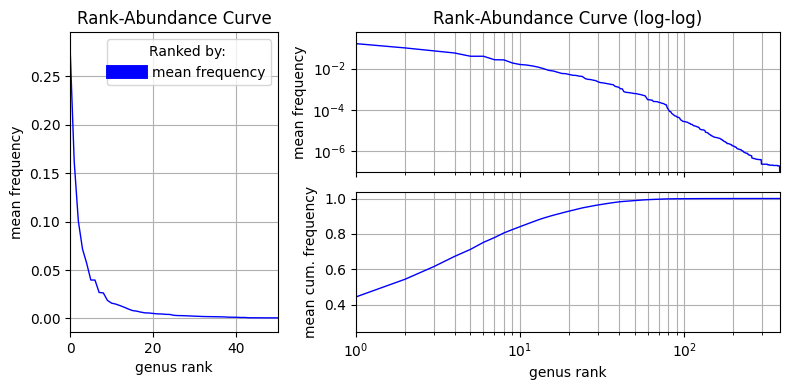

In [54]:
out_path = os.path.join(directory, "Genus_RAD.png")
fig = plt.figure(figsize=(8, 4))

gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[1, 1], width_ratios=[3, 3, 2])
ax1 = fig.add_subplot(gs[0, 1:3])
ax2 = fig.add_subplot(gs[1, 1:3])
ax3 = fig.add_subplot(gs[:, 0])
ax = [ax1, ax2, ax3]


l = 1 # linewidth
color_mean = "blue"
color_median = "orange"

x = np.arange(0, len(df))
y = df["mean_frequency"] 
y_cum = df["cum_mean_frequency"] 
ax[0].plot(x, y, color = color_mean, linewidth = l)#, label = f'mean frequency')
ax[2].plot(x, y, color = color_mean, linewidth = l, label = f'mean frequency')
ax[1].plot(x, y_cum, color = color_mean,linewidth = l)#, label = f'mean frequency')


#y = df["median_frequency"]
#y_cum = df["cum_median_frequency"]
#ax[0].plot(x, y, color = color_median, linewidth = l)#, label = f'median frequency')
#ax[2].plot(x, y, color = color_median, linewidth = l, label = f'median frequency')
#ax[1].plot(x, y_cum, color = color_median, linewidth = l)#, label = f'median frequency')



# Global plot aestethics
ax[0].set_xlim(1, len(df))
ax[0].tick_params(labelbottom=False)
ax[1].set_xlim(1, len(df))
ax[0].set_title("Rank-Abundance Curve (log-log)", fontsize = 'large')
ax[0].set_xlabel("")
ax[0].set_ylabel("mean frequency")
ax[0].grid(which= "both", axis = "x")
ax[0].grid(which= "major", axis = "y")
legend = ax[2].legend(title = "Ranked by: ")
for line in legend.get_lines():
    line.set_linewidth(10)

ax[2].set_xlim(0, 50)
ax[2].set_xticks(np.arange(0, 50, 20))
ax[2].set_xlabel("genus rank")
ax[2].set_title("Rank-Abundance Curve", fontsize = 'large')
ax[2].set_ylabel("mean frequency")
ax[2].grid(which= "both", axis = "x")
ax[2].grid(which= "major", axis = "y")


#ax[1].set_title("Cum. Rank-Abundance Curve", fontsize = 'large')
ax[1].set_xlabel("genus rank")
ax[1].set_ylabel("mean cum. frequency")
#ax[1].set_yticks(np.arange(0, 1.1, 0.2))
ax[1].grid(which= "both", axis = "x")
ax[1].grid(which= "major", axis = "y")


ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_xscale("log")


plt.subplots_adjust(wspace = 0.4)
plt.tight_layout()
plt.savefig(out_path, dpi = 600)


### Helper function to create dataframes for each mouse, with counts grouped by genus

In [4]:
def get_mouse_genus_df_list():
    info_df = mi.metadata_df[["Species", "Genus"]].drop_duplicates()
    info_df.rename(columns={"Species": "species"}, inplace=True)
    dir = "Data/by_mouse_genus_aggregated"
    os.makedirs(dir, exist_ok = True)
    mouse_genus_df_list = []
    for mouse in range(0, 8):
        mouse_genus_df = mi.get_mice_df()[mouse].copy()
        mouse_genus_df = pd.merge(mouse_genus_df, info_df, on="species", how="left")
        
        cols = mouse_genus_df.columns[1:-1]
        mouse_genus_df = mouse_genus_df.groupby("Genus")[cols].sum().reset_index()
        mouse_genus_df["mean"] = mouse_genus_df[cols].mean(axis = 1)
        mouse_genus_df["median"] = mouse_genus_df[cols].median(axis = 1)
        mouse_genus_df.sort_values(by = "median", ascending = False, inplace = True)
        mouse_genus_df.reset_index(drop=True, inplace = True)
        mouse_genus_df.to_csv(f"{dir}/mouse_{mouse}_genus.csv", index = False)
        mouse_genus_df_list.append(mouse_genus_df)
        return mouse_genus_df_list

def get_genus_df(genus='Prevotella', output_dir="Data/by_genus", force = False) -> pd.DataFrame:

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Check if already existing   
    filepath = os.path.join(output_dir, f"{genus}.csv")
    if not force and os.path.isfile(filepath):
        return pd.read_csv(filepath)
    
    day_max = int(mi.mice_df[0].columns[-1])  # Assume mouse 0 lives the longest
    days = np.arange(day_max + 1)
    mouse_df_list = []
    mouse_idxs_list = []

    mouse_genus_df_list = get_mouse_genus_df_list()
    for n in range(mi.subjects):
        df = mouse_genus_df_list[n].copy()
        df = df[df['Genus'] == genus].iloc[:, 1:]  # Skip 'genus' column
        genus_data = []

        if not df.empty:
            for day in days:
                if day not in df.columns or df[day].empty:
                    genus_data.append({'day': day, f'mouse_{n}': np.nan})
                else:
                    genus_data.append({'day': day, f'mouse_{n}': df[day].iloc[0]})
        else:
            for day in days:
                genus_data.append({'day': day, f'mouse_{n}': 0})

        mouse_df_list.append(pd.DataFrame(genus_data))
        mouse_idxs_list.append(n)

    mouse_columns = [f'mouse_{n}' for n in mouse_idxs_list]
    genus_df = mouse_df_list[0]
    for i in range(1, len(mouse_df_list)):
        genus_df = pd.concat([genus_df, mouse_df_list[i]], axis=1)

    genus_df = genus_df.loc[:, ~genus_df.columns.duplicated()]
    genus_df['mean'] = genus_df[mouse_columns].mean(axis=1, skipna=True)
    genus_df['std'] = genus_df[mouse_columns].std(axis=1, skipna=True)

    output_path = os.path.join(output_dir, f"{genus}.csv")
    genus_df.to_csv(output_path, index=False)

    return genus_df

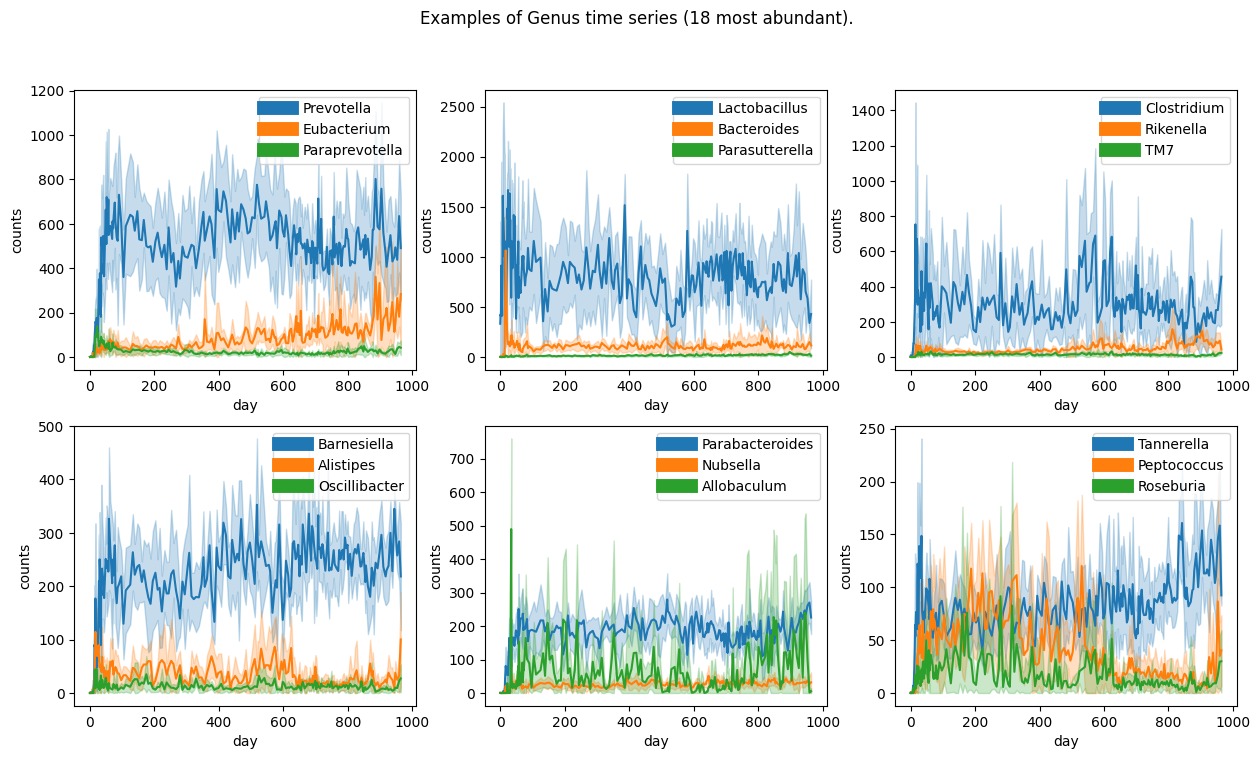

In [12]:
df = get_mouse_genus_df_list()[0]
N = 18
offset = 0
genera_to_plot = df["Genus"].iloc[offset:(N+offset)].tolist()

naxis = 6
from matplotlib import colormaps as cm
colors = cm.get_cmap('tab10')

fig, axes = plt.subplots(2, naxis // 2, figsize=(5 * 3, 8))

axes = axes.flatten()
for i,genus in enumerate(genera_to_plot):
    prova = get_genus_df(genus = genus)
    ax = axes[i % naxis]  # Choose subplot based on i % 4
    # Plot mean and std
    valid_data = prova[['day', 'mean', 'std']].dropna()
    ax.plot(valid_data['day'], valid_data['mean'], color=colors(i // naxis), linewidth=1.5, label=genus)
    ax.fill_between(valid_data['day'], 
            y1=np.maximum(valid_data['mean'] - valid_data['std'], 0),
            y2=valid_data['mean'] + valid_data['std'], 
            color= colors(i // naxis), alpha=0.25)
    ax.set_xlabel("day")
    ax.set_ylabel("counts")
    legend = ax.legend()
    for line in legend.get_lines():
        line.set_linewidth(10)

plt.suptitle(f"Examples of Genus time series ({N} most abundant).")
plt.savefig(os.path.join(directory, "example_genus_ts.png"), dpi = 300)

# _________________________________________________________________

# _________________________________________________________________
# Time Series Analyisis


 Looking at time series: testing the null hypotesis of stationarity.



Before going on with the stochastic logistic model, we should - at least -  test the null hypotesis of stationarity. Two main tests can be used:

- The augmented dickey-fuller (ADF) test: models the time series as an autoregressive model of order p-th and checks if its is stationary by analyzing the roots of the poli

- KPSS test: decomposes as moving average plus white noise. checks if this moving average is constant.

### Analyis of correlograms (the sample ACF)

In a stationary process, we expect ACF(k) to eventually settle to zero as the lag k increases - either abruptly, or in an oscillating fashion, or exponentially like, or with some other trend, depending on the underlying process.

When looking at correlograms, we can already perform a statistic test on the null hypotesis that the series is **pure white noise**. Individual sample autocorrelations would be approximately distributed with mean zero and variance 1/T under the hypotesis that the series is white noise.



**Definition** Autocorrelation Function (ACF) of a time series ${x_t}$

$$
ACF(k, t) = \frac{Cov(x_t, x_{t-k})}{Cov(x_t, x_t)}
$$

For a *stationary* time series, ACF depends only on the lag $k$, not on the absolute time $t$. It becomes:

$$
ACF(k) = \frac{Cov(x_t, x_{t-k})}{Cov(x_0, x_0)} = \frac{Cov(x_t, x_{t-k})}{Var(x_0)}
$$


However, we have a finite time series, of length T, therefore we will *estimate* the ACF, but not know it exactly. Our sample estimate is:


$$
\tilde{ACF}(k) = \frac{\frac{1}{N-k-1} \sum_{t = K + 1}^T (x_t - \overline{x})\cdot(x_{t-k} - \overline{x})}{\frac{1}{N-1} \sum_{t=1}^T (x_t - \overline{x})^2} 
$$

where $\overline{x}= \frac{1}{T} \sum_{t=1}^T x_t$ is the sample mean.

We need to associate an error on ACF(k). The error we associate will depends on our underlying assumption on the time series. 

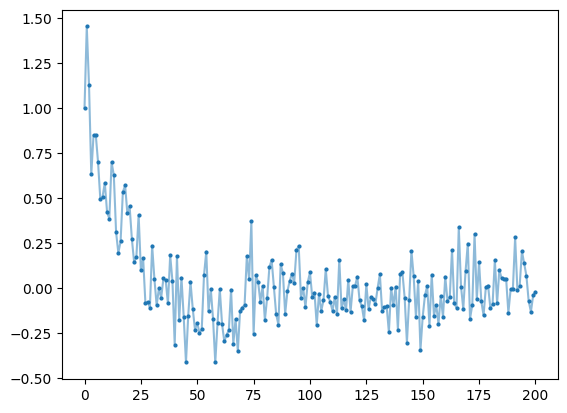

In [6]:
from statsmodels.tsa.stattools import acf


df = pd.read_csv("Data/by_mouse_transposed/mouse_1_transposed.csv")
times = df["day"].to_numpy(dtype=int)
counts = df["Prevotella sp. Smarlab 121567"].copy()#.to_numpy(dtype=int)

lag_max = 200
acf_ = acf(x = counts, nlags = lag_max, qstat = False, adjusted = True, missing = "conservative")

plt.plot(np.arange(0, lag_max + 1), acf_, alpha = 0.5)
plt.scatter(np.arange(0, lag_max + 1), acf_, s = 4)


In [7]:
from scipy.stats import chi2


# Anatomy of stattools.acovf
# Super nice code! 
# My own attempt was a mess with respect to this
# A reminder to always use pre-built functions when available!

#x = np.array([1, np.nan, 2, 3,5,6,np.nan])


def acf_with_missing(y, return_ljung_box = False):

    x = y.copy()
    n = len(x)
    notmask_bool = ~np.isnan(x)  # bool
    notmask_int = notmask_bool.astype(int) # zeros for nan
    # Must copy for thread safety
    x[~notmask_bool] = 0
    #print(x)
    #print(notmask_int)
    xo = x - x.sum() / notmask_int.sum()
    xo[~notmask_bool] = 0
    #print(xo)

    
    # compute number of valid pairs
    d = np.correlate(notmask_int, notmask_int, "full")
    #print("lags:", np.arange(0, len(d)) - (n-1))
    #print(d)
    # only consider positive lags:
    #print("lags:", np.arange(n-1, len(d))- (n-1))
    #print(d[n-1 :])
    valid_pairs = d[n - 1 :] != 0
    d[d == 0] = 1
    acov = np.correlate(xo, xo, "full")[n - 1 :] / d[n - 1 :]
    acov[~valid_pairs] = np.nan
    #print(acov)
    # White noise errors
    white_errors = 1/ np.sqrt(d[n-1 :])
    white_errors[~valid_pairs] = np.nan
    acf = acov/acov[0]
    if return_ljung_box == False:
        return acf, white_errors
    else:
    # Ljung box statistics
        ret = (
            n
            * (n + 2)
            * np.cumsum((1.0 / d[n - 1 :]) * acf ** 2)
        )
        chi2_ = chi2.sf(x = ret, df = np.arange(1, n+1))
        return acf, white_errors, ret, chi2_

#acov = acf_with_missing(x)
x = counts.to_numpy()
lag_max = len(x)

acf_mine, white_errors = acf_with_missing(x)

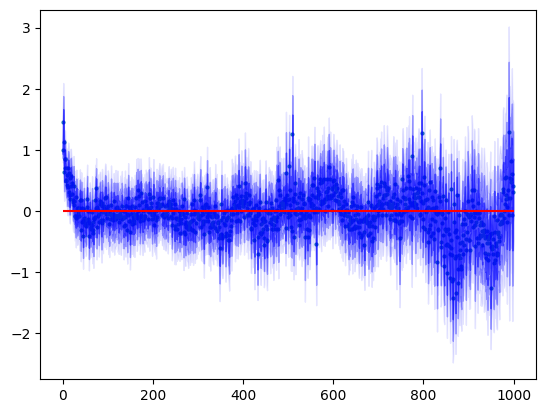

In [8]:
x = counts.to_numpy()
lag_max = len(x)

acf_mine, white_errors = acf_with_missing(x)


acf_ = acf(x, nlags= lag_max, adjusted = True, missing = "conservative")



lag_max_plot = 1000
#plt.plot(np.arange(0, lag_max_plot), acf_mine[0:lag_max_plot], color = "blue", linewidth = 0.1, alpha = 1,label = "mine")
plt.scatter(np.arange(0, lag_max_plot), acf_mine[0: lag_max_plot], s = 4)
plt.fill_between(x = np.arange(0, lag_max_plot), y1 =acf_mine[0: lag_max_plot] - white_errors[0:lag_max_plot], y2 =acf_mine[0: lag_max_plot] + white_errors[0:lag_max_plot], color = "blue", alpha = 0.5 )
plt.fill_between(x = np.arange(0, lag_max_plot), y1 =acf_mine[0: lag_max_plot] - 2* white_errors[0:lag_max_plot], y2 =acf_mine[0: lag_max_plot] + 2*white_errors[0:lag_max_plot], color = "blue", alpha = 0.3 )
plt.fill_between(x = np.arange(0, lag_max_plot), y1 =acf_mine[0: lag_max_plot] - 3* white_errors[0:lag_max_plot], y2 =acf_mine[0: lag_max_plot] + 3*white_errors[0:lag_max_plot], color = "blue", alpha = 0.1 )
plt.hlines( y= 0, xmin = 0, xmax = lag_max_plot, color = "red")
#plt.plot(np.arange(0, lag_max_plot), acf_[0: lag_max_plot], alpha = 0.5, label = "library")
#plt.scatter(np.arange(0, lag_max_plot), acf_[0: lag_max_plot], s = 4)
#plt.legend()

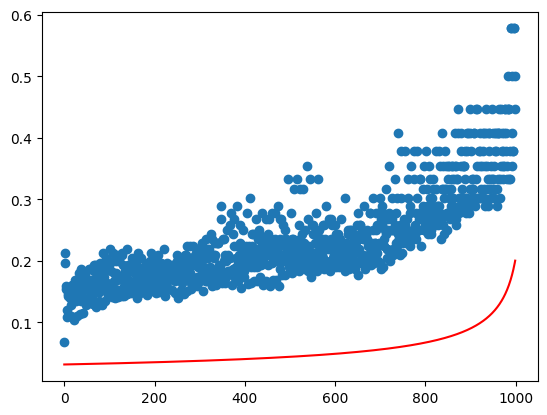

In [79]:
lag_max_plot = 1000
plt.scatter(np.arange(0, lag_max_plot), white_errors[0: lag_max_plot])

# expected without missing data
x = np.arange(0, lag_max_plot)
N = 1024
plt.plot(x, 1/np.sqrt(N - x), color = "red")

#### White noise test

Liung - Box q statistics

$Q = T\cdot (T+2)  \sum_{k=1}^p \, \frac{r_k^2}{T-k}$

$Q \rightarrow \Chi^2$ with $p$ degrees of freedom in the infinite sample limit


How to choose p (the maximum number of lags)? 

Depends on the time series length. It should not be too small, but also not too large because for large p the estimate of ACF(p) becomes too noisy.

In [60]:
from statsmodels.tsa.stattools import q_stat

lags_list = 100

ret, chi2 = q_stat(x = acf_mine, nobs = 1024)



for i, lag in enumerate(ret):
    print(f"lag: {lag} chi2: {chi2[i]}")
#print(chi2) # sf(x, df) survival function (1- cdf(x, df)) df = degrees of freedom

lag: 1027.0029325513196 chi2: 2.4259347512950435e-225
lag: 3198.6229190738172 chi2: 0.0
lag: 4503.2287050749865 chi2: 0.0
lag: 4913.928656595698 chi2: 0.0
lag: 5658.463521206025 chi2: 0.0
lag: 6403.978300476457 chi2: 0.0
lag: 6908.963370495463 chi2: 0.0
lag: 7161.657265733235 chi2: 0.0
lag: 7427.865201193435 chi2: 0.0
lag: 7781.565076002093 chi2: 0.0
lag: 7966.035007584263 chi2: 0.0
lag: 8119.6343032940395 chi2: 0.0
lag: 8628.217194887635 chi2: 0.0
lag: 9036.510063993348 chi2: 0.0
lag: 9136.590305118478 chi2: 0.0
lag: 9176.29362013858 chi2: 0.0
lag: 9245.783956171614 chi2: 0.0
lag: 9541.906452985573 chi2: 0.0
lag: 9882.212232945125 chi2: 0.0
lag: 10062.247908823188 chi2: 0.0
lag: 10278.969584172168 chi2: 0.0
lag: 10357.087223858909 chi2: 0.0
lag: 10378.649540717535 chi2: 0.0
lag: 10409.67375680027 chi2: 0.0
lag: 10583.048974518817 chi2: 0.0
lag: 10593.111253436802 chi2: 0.0
lag: 10621.67858307411 chi2: 0.0
lag: 10628.908647466975 chi2: 0.0
lag: 10635.274602783133 chi2: 0.0
lag: 10647.9

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:570: RuntimeWarning: divide by zero encountered in divide
  * np.cumsum((1.0 / (nobs - np.arange(1, len(x) + 1))) * x ** 2)


lags: [0 1 2 3 4 5 6 7 8]
[6 3 3 3 2 2 1 0 1]


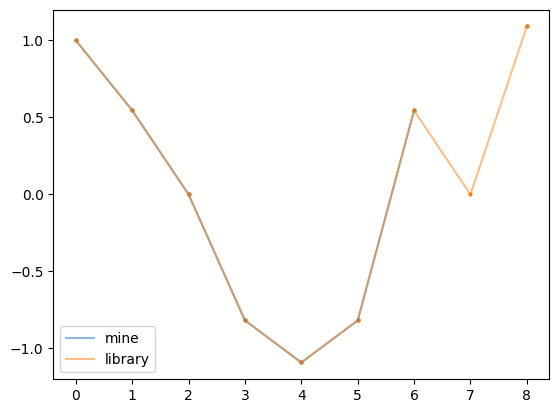

In [8]:
x = np.array([1, np.nan, 2, 3,5,6,np.nan, np.nan, 1])
#x = counts.to_numpy()
lag_max = len(x)

acov = acf_with_missing(x)


acf_ = acf(x, nlags= lag_max, adjusted = True, missing = "conservative")


lag_max_plot = min(lag_max, 10)
plt.plot(np.arange(0, lag_max_plot), acov[0:lag_max_plot]/acov[0], alpha = 0.5,label = "mine")
plt.scatter(np.arange(0, lag_max_plot), acov[0: lag_max_plot]/acov[0], s = 4)
plt.plot(np.arange(0, lag_max_plot), acf_[0: lag_max_plot], alpha = 0.5, label = "library")
plt.scatter(np.arange(0, lag_max_plot), acf_[0: lag_max_plot], s = 4)
plt.legend()

lags: [   0    1    2 ... 1041 1042 1043]
[217  22  26 ...   0   0   1]


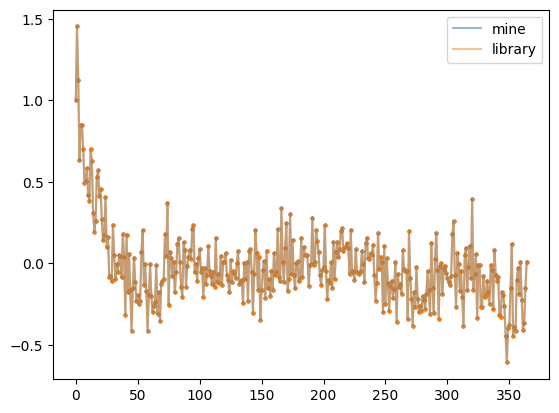

In [9]:
#x = np.array([1, np.nan, 2, 3,5,6,np.nan, np.nan, 1])
x = counts.to_numpy()
lag_max = len(x)

acov = acf_with_missing(x)


acf_ = acf(x, nlags= lag_max, adjusted = True, missing = "conservative")


lag_max_plot = 365
plt.plot(np.arange(0, lag_max_plot), acov[0:lag_max_plot]/acov[0], alpha = 0.5,label = "mine")
plt.scatter(np.arange(0, lag_max_plot), acov[0: lag_max_plot]/acov[0], s = 4)
plt.plot(np.arange(0, lag_max_plot), acf_[0: lag_max_plot], alpha = 0.5, label = "library")
plt.scatter(np.arange(0, lag_max_plot), acf_[0: lag_max_plot], s = 4)
plt.legend()


Riassunto: la funzione pre-built di statstools fa quello che deve, con l'unico difetto che però non distingue nell output finale le correlazioni che sono 0. perchè non c'erano coppie valide su cui calcolarle (e che quindi dovrebbero essere dei nan a rigore) dagli zeri "reali".

Ora devo stimare gli errori e capire cos'è il test di Lijung-Box per l'ipotesi nulla di white noise.



Rispetto agli errori, leggo da statsmodels:


bartlett_confint : bool, default True
Confidence intervals for ACF values are generally placed at 2 standard errors around r_k. The formula used for standard error depends upon the situation. If the autocorrelations are being used to test for randomness of residuals as part of the ARIMA routine, the standard errors are determined assuming the residuals are white noise. The approximate formula for any lag is that standard error of each r_k = 1/sqrt(N). See section 9.4 of [2] for more details on the 1/sqrt(N) result. For more elementary discussion, see section 5.3.2 in [3]. For the ACF of raw data, the standard error at a lag k is found as if the right model was an MA(k-1). This allows the possible interpretation that if all autocorrelations past a certain lag are within the limits, the model might be an MA of order defined by the last significant autocorrelation. In this case, a moving average model is assumed for the data and the standard errors for the confidence intervals should be generated using Bartlett's formula. For more details on Bartlett formula result, see section 7.2 in [2]

#### ACF for all species

In [ ]:
df = pd.read_csv("Data/by_mouse_transposed/mouse_1_transposed.csv")
times = df["day"].to_numpy(dtype=int)


acf_list = []
errors_list = []
names_list = []

for ncol in np.arange(1, 11):
    name = df.columns[ncol]
    counts = df[f"{name}"].copy()#.to_numpy(dtype=int)
    x = counts.to_numpy()
    lag_max = len(x)
    acf_mine, white_errors = acf_with_missing(x)
    acf_list.append(acf_mine)
    errors_list.append(white_errors)
    names_list.append(name)

NameError: name 'acf_with_missing' is not defined

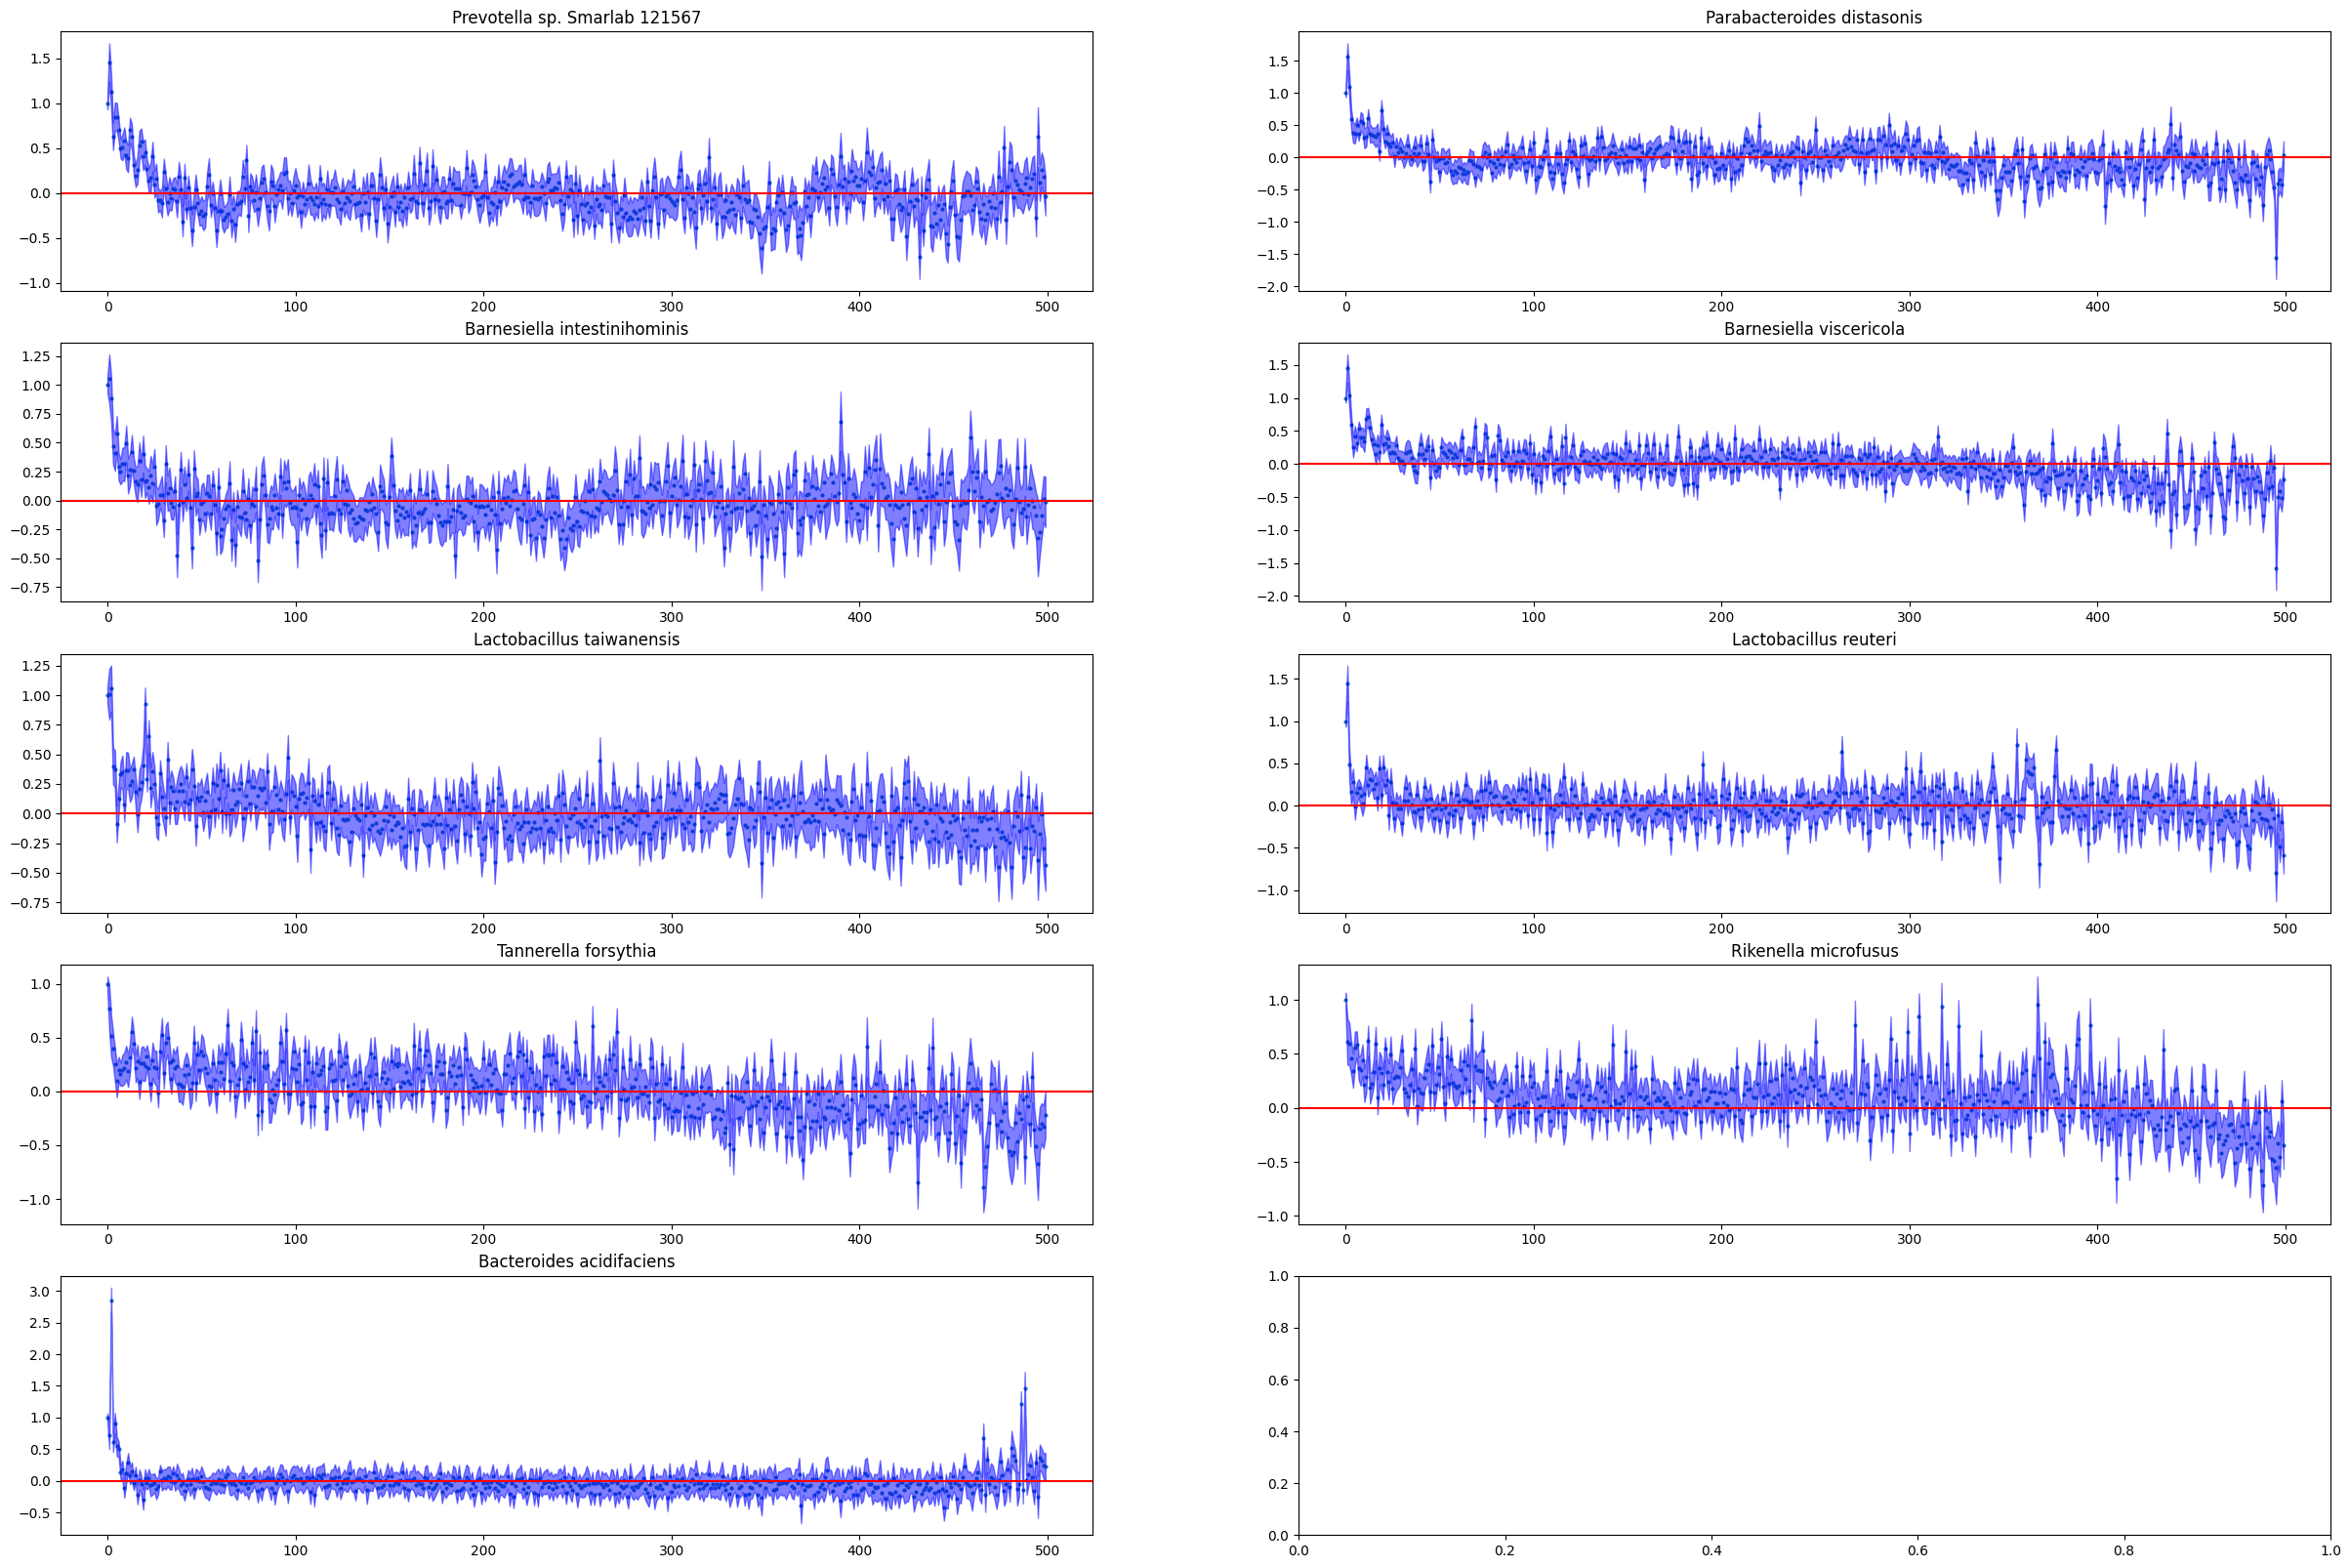

In [100]:
lag_max_plot = 500

fig, axs =plt.subplots(nrows = 5, ncols = 2, figsize = (30, 20))

axs = axs.flatten()
for i in np.arange(0, 9):
    ax = axs[i]
    acf_mine = acf_list[i]
    white_errors = errors_list[i]
    name = names_list[i]
    ax.scatter(np.arange(0, lag_max_plot), acf_mine[0: lag_max_plot], s = 4)
    ax.fill_between(x = np.arange(0, lag_max_plot), y1 =acf_mine[0: lag_max_plot] - white_errors[0:lag_max_plot], y2 =acf_mine[0: lag_max_plot] + white_errors[0:lag_max_plot], color = "blue", alpha = 0.5 )
    #ax.fill_between(x = np.arange(0, lag_max_plot), y1 =acf_mine[0: lag_max_plot] - 2* white_errors[0:lag_max_plot], y2 =acf_mine[0: lag_max_plot] + 2*white_errors[0:lag_max_plot], color = "blue", alpha = 0.3 )
    #ax.fill_between(x = np.arange(0, lag_max_plot), y1 =acf_mine[0: lag_max_plot] - 3* white_errors[0:lag_max_plot], y2 =acf_mine[0: lag_max_plot] + 3*white_errors[0:lag_max_plot], color = "blue", alpha = 0.1 )
    ax.axhline( y= 0, xmin = 0, xmax = lag_max_plot, color = "red")
    ax.set_title(f"{name}")

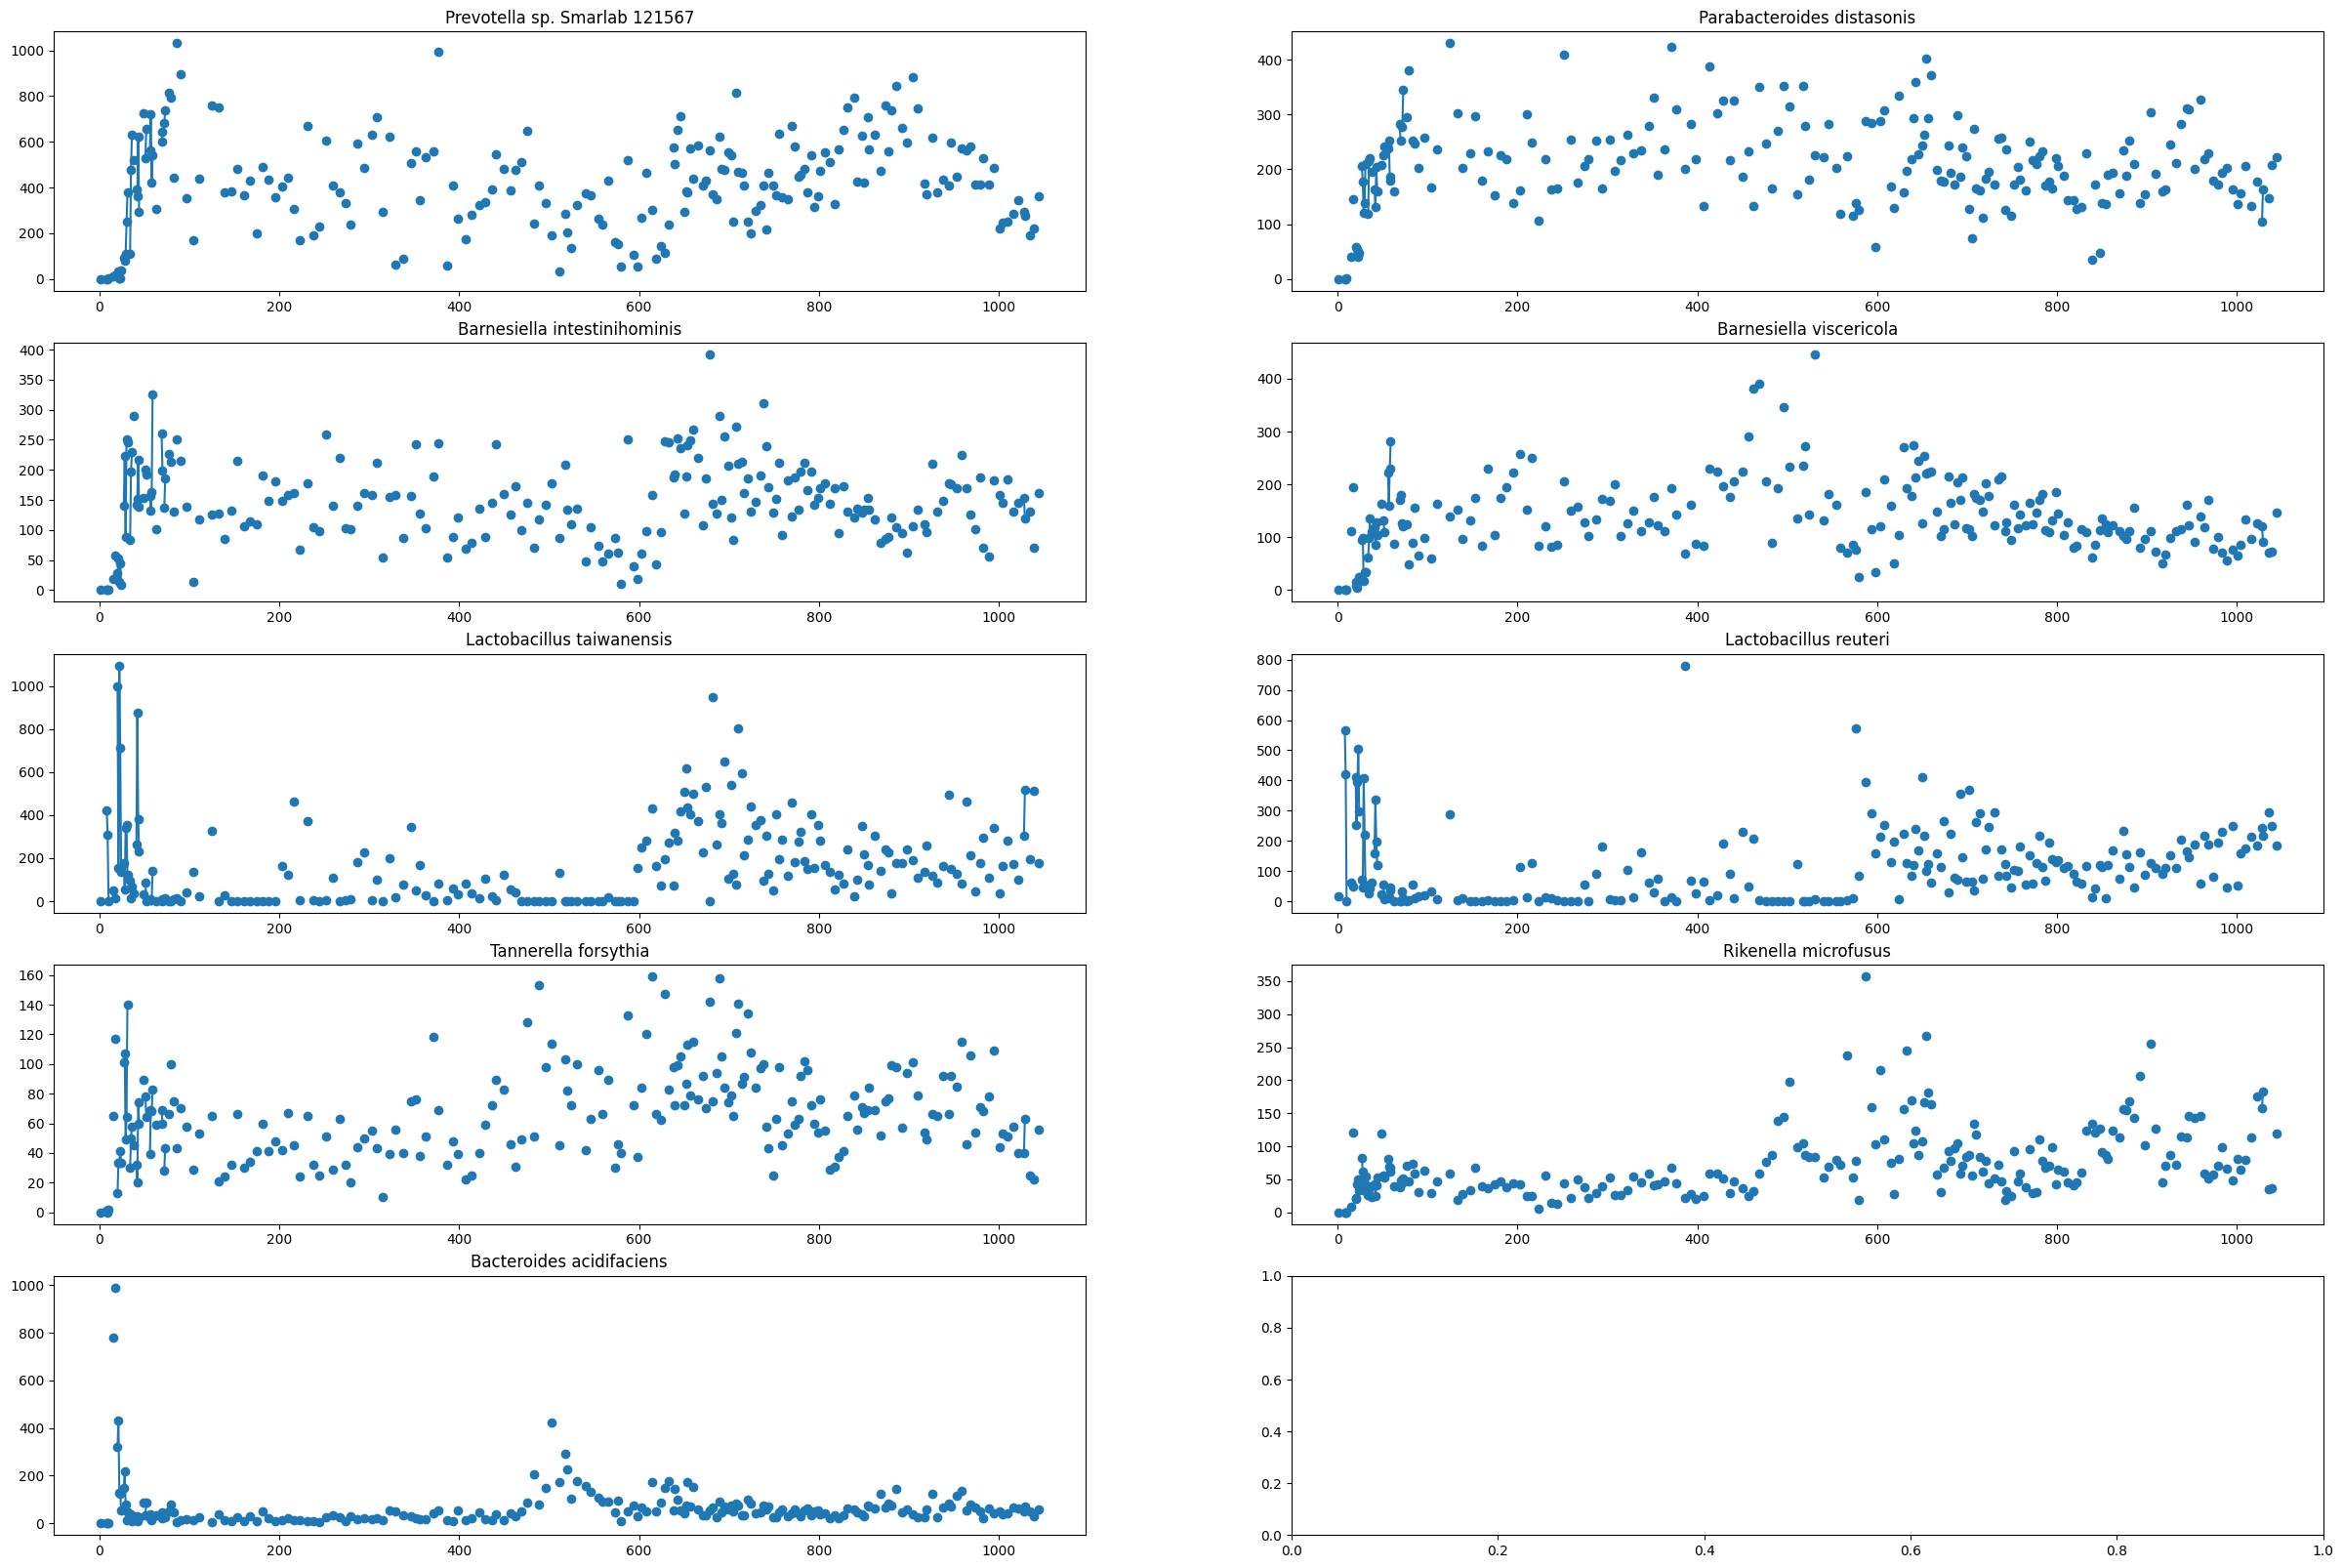

In [97]:
fig, axs =plt.subplots(nrows = 5, ncols = 2, figsize = (30, 20))

axs = axs.flatten()
for i in np.arange(0, 9):
    ax = axs[i]
    counts = df.iloc[:, i+1].copy()
    ax.scatter(times, counts)
    ax.plot(times, counts)
    ax.set_title(names_list[i])